## Kosten van uniforme doorsnede-eisen
Een belangrijke vraag bij het ontwerp is de verdeling van doorsnede-eisen over de mechanismen.
In dit notebook kijken we naar de kosten van verschillende ontwerpeisen, waarbij we de ontwerpeisen uniform houden per dijkvak. 
Dat geeft inzicht in:
* Wat optimale (uniforme/top-down) eisen zijn voor het traject
* Wat de eventuele meerwaarde is van het varieren van eisen over mechanismen en vakken (conform veiligheidsrendement)

We kunnen naar verschillende trajecten kijken. Eerst vergelijken we veiligheidsrendement met uniforme (top-down) ontwerpeisen. Daarna kijken we naar de verdeling van faalkans over de lengte van het traject (hoeveel van de trajectlengte draagt bij?).

In [1]:
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.stats import norm
from peewee import fn
import itertools
from vrtool.orm.models import *
from vrtool.orm.orm_controllers import open_database
from vrtool.common.enums import MechanismEnum
from postprocessing.database_analytics import *
from postprocessing.database_access_functions import * 

from postprocessing.vrtool_optimization_object import VRTOOLOptimizationObject
from postprocessing.vrtool_measures_object import VRTOOLMeasuresObject

from postprocessing.generate_output import *
import matplotlib.pyplot as plt

from common_functions.Deltares_colors import Deltares_colors 
sns.set(style="whitegrid")
colors =  Deltares_colors().sns_palette("DeltaresFull")

In [2]:
# root_dir = Path(r"n:\Projects\11209000\11209353\B. Measurements and calculations\008 - Resultaten Proefvlucht\Alle_Databases\met lengte-effecten (N=4)")
# root_dir = Path(r"n:\Projects\11209000\11209353\B. Measurements and calculations\008 - Resultaten Proefvlucht\Alle_Databases\met lengte-effecten")
root_dir = Path(r"c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\38-1\N=4 database")
# root_dir = Path(r"n:\Projects\11209000\11209353\B. Measurements and calculations\008 - Resultaten Proefvlucht\Alle_Databases")
db_path = root_dir.joinpath("38-1","38-1_basis.db")
# db_path = root_dir.joinpath("10-1","database_10-1_LBO1.sqlite")
# db_path = root_dir.joinpath("10-1","database_10-1_trajectaanpak.sqlite")
# db_path = root_dir.joinpath("10-2","database_10-2.sqlite")
# db_path = root_dir.joinpath("10-3","database_10-3.sqlite")
# db_path = root_dir.joinpath("24-3","24-3_database.db")
# db_path = root_dir.joinpath("16-1","16-1_results.db")

# db_path = Path(r"n:\Projects\11209000\11209353\B. Measurements and calculations\008 - Resultaten Proefvlucht\Alle_Databases\met lengte-effecten\10-1\database_10-1_LBO1.sqlite")
# db_path = Path(r"n:\Projects\11209000\11209353\B. Measurements and calculations\008 - Resultaten Proefvlucht\Alle_Databases\10-2\database_10-2.sqlite")
# db_path = Path(r"n:\Projects\11209000\11209353\B. Measurements and calculations\008 - Resultaten Proefvlucht\Alle_Databases\met lengte-effecten\24-3\24-3_database.db")
has_revetment = False
LE = 4 # ['no', 4, 'full'] 
# LE = 'full'
# LE = 'no'

_runs_overview = get_overview_of_runs(db_path)
_runs_overview

[{'id': 1,
  'name': 'Basisberekening Veiligheidsrendement',
  'discount_rate': 0.016,
  'optimization_type': 1,
  'optimization_type_name': 'VEILIGHEIDSRENDEMENT'},
 {'id': 2,
  'name': 'Basisberekening Doorsnede-eisen',
  'discount_rate': 0.016,
  'optimization_type': 2,
  'optimization_type_name': 'DOORSNEDE-EISEN'}]

In [3]:
vrm_run = VRTOOLOptimizationObject(db_path, 1)
vrm_run.get_all_optimization_results()


Now we are going to read the measures for each section, and for a grid of probabilities determine the costs associated with meeting a set of requirements for overflow, stability & piping. This grid runs from the standard to 100000 more stringent for each.

In [4]:
measure_set = VRTOOLMeasuresObject(db_path, LE_scenario=LE)

In [10]:
class UniformRequirementsAnalysis:
    def __init__(self, measures, total_space= 1.0):
        '''Total space sets the omega for all considered mechanisms'''
        
        self.p_max = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).p_max
        self.p_max_space = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).p_max * total_space
        self.omega_piping = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).omega_piping
        self.omega_stability_inner = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).omega_stability_inner
        self.omega_overflow = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).omega_overflow
        # self.omega_revetment = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).omega_revetment
        self.omega_revetment = 0.10
        self.a_piping = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).a_piping
        self.a_stability_inner = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).a_stability_inner
        self.b_stability_inner = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).b_stability_inner
        self.b_piping = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).b_piping
        self.traject_length = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_length
        
        self.measures = measures.measures_for_all_sections


    def make_Nbased_grid(self, N_omega, N_LE, revetment = False):
        #step 2: make a grid
        #smaller grid
        N_omega = [2., 3., 4., 6., 8., 16., 32.]
        N_LE = [5., 10., 20., 40., 50.]


        N_overflow_grid = N_omega.copy()
        N_overflow_grid = N_overflow_grid + [np.divide(1, self.omega_overflow)]
        overflow_grid = pf_to_beta(np.divide(self.p_max, N_overflow_grid))
        
        N_piping_grid = sorted(set([a*b for a,b in list(itertools.product(N_omega, N_LE))]))
        N_piping_grid = N_piping_grid + [np.divide(1,self.omega_piping) * np.divide(self.a_piping * self.traject_length, self.b_piping )]
        piping_grid = pf_to_beta(np.divide(self.p_max, N_piping_grid))

        #add existing values:
        N_stability_inner_grid = sorted(set([a*b for a,b in list(itertools.product(N_omega, N_LE))]))
        N_stability_inner_grid = N_stability_inner_grid + [np.divide(1,self.omega_stability_inner) * np.divide(self.a_stability_inner * self.traject_length, self.b_stability_inner)]
        stability_inner_grid = pf_to_beta(np.divide(self.p_max, N_stability_inner_grid))

        if revetment:
            N_revetment_grid = N_omega.copy()
            N_revetment_grid = N_revetment_grid + [np.divide(1, self.omega_revetment)]
            revetment_grid = pf_to_beta(np.divide(self.p_max, N_revetment_grid))  
        #make a beta_grid for all
                                        
        # #make a grid for all mechanisms. 
        if revetment:
            target_beta_grid_all = itertools.product(overflow_grid, piping_grid, stability_inner_grid, revetment_grid)
        else:
            target_beta_grid_all = itertools.product(overflow_grid, piping_grid, stability_inner_grid)

        self.target_beta_grid_all = list(target_beta_grid_all)
        

    
    def make_dict_based_grid(self, omega_grids, LE_grid = False):
        #step 2: make a grid based on a dict with emchanisms as keys and values in lists
        #omega_grid contains lists of values expressed as N, should be same length
        #check length of .values in N_omega_dict
        if len(set([len(values) for values in omega_grids.values()])) != 1:
            raise ValueError('Lists of values in omega_grids should have the same length')
        
        if LE_grid: #now we have more than 1 LE parameterization
            if len(set([len(values) for values in LE_grid.values()])) != 1:
                raise ValueError('Lists of values in N_LE_dict should have the same length')
            LE_grid[MechanismEnum.OVERFLOW] = [1] * (len(list(LE_grid.values())[0])+1)
            LE_grid[MechanismEnum.REVETMENT] = [1] * (len(list(LE_grid.values())[0])+1)  
        
            LE_grid[MechanismEnum.PIPING] = [self.a_piping * self.traject_length / self.b_piping] + [a_traject * self.traject_length / self.b_piping for a_traject in list(LE_grid[MechanismEnum.PIPING])]
            LE_grid[MechanismEnum.STABILITY_INNER] = [self.a_stability_inner * self.traject_length / self.b_stability_inner] + [a_traject * self.traject_length / self.b_stability_inner for a_traject in list(LE_grid[MechanismEnum.STABILITY_INNER])]
        else:
            LE_grid = {MechanismEnum.OVERFLOW: [1], MechanismEnum.REVETMENT: [1], MechanismEnum.PIPING: [self.a_piping * self.traject_length / self.b_piping], MechanismEnum.STABILITY_INNER: [self.a_stability_inner * self.traject_length / self.b_stability_inner]}

        N_specific_grids = {mechanism: list(itertools.product(omega_grids[mechanism], LE_grid[mechanism])) for mechanism in omega_grids.keys()}
        #for each value in the list of values in specific grids we compute the product of the tuple
        N_specific_grids = {mechanism: [a*b for a,b in values] for mechanism, values in N_specific_grids.items()}

        #make a beta_grid for all
        self.specific_target_beta_grid = {mechanism: pf_to_beta(np.divide(self.p_max, N_specific_grids[mechanism])) for mechanism in omega_grids.keys()}
        
        #N_LE_dict contains a_traject values for piping, stability. Is optional and will be added to the default values.
        
        pass
    
    @staticmethod
    def compute_traject_probability(minimal_cost_dataset):
        #no upscaling in sections. 
        pf_overflow = max(beta_to_pf(minimal_cost_dataset['Overflow']))
        p_nonf_piping = np.product(np.subtract(1,beta_to_pf(minimal_cost_dataset['Piping'])))
        p_nonf_stability = np.product(np.subtract(1,beta_to_pf(minimal_cost_dataset['StabilityInner'])))
        pf_traject = 1- (1-pf_overflow)*(p_nonf_piping)*(p_nonf_stability)
        return pf_traject

    @staticmethod
    def calculate_cost(overflow_beta, piping_beta, stability_beta, measures_df, revetment_beta = None):
        #calculate the cost for the given beta values

        #get all sections
        sections = measures_df['section_id'].unique()

        if revetment_beta == None:
            possible_measures = measures_df.loc[(measures_df['Overflow_dsn'] >= overflow_beta) & 
                            (measures_df['Piping_dsn'] >= piping_beta) & 
                                (measures_df['StabilityInner_dsn'] >= stability_beta)]
        else:
            possible_measures = measures_df.loc[(measures_df['Overflow_dsn'] >= overflow_beta) & 
                            (measures_df['Piping_dsn'] >= piping_beta) & 
                                (measures_df['StabilityInner_dsn'] >= stability_beta) &
                                    (measures_df['Revetment_dsn'] >= revetment_beta)]
        #get the minimal cost for each section_id and the betas that belong to that measure
        minimal_costs_idx = possible_measures.reset_index().groupby('section_id')['cost'].idxmin()
        minimal_costs_data = possible_measures.reset_index().loc[minimal_costs_idx]

        computed_traject_probability = UniformRequirementsAnalysis.compute_traject_probability(minimal_costs_data)

        minimal_costs = minimal_costs_data['cost']
        #check if all sections are in the minimal_costs, if any of them is not in there return 1e99, else return the sum of the costs
        if len(sections) != len(minimal_costs):
            return 1e99, computed_traject_probability, minimal_costs_data
        else:
            return minimal_costs.sum(), computed_traject_probability, minimal_costs_data
    
    def analyze_Nbased_grid(self):
        cost_grid = []
        pf_traject = []

        if len(self.target_beta_grid_all[0]) == 3:  #no revetment
            for count, (overflow_beta, piping_beta, stability_beta) in enumerate(self.target_beta_grid_all):
                cost_i, pf_traject_i, measures_per_section_for_step =  self.calculate_cost(overflow_beta, piping_beta, stability_beta, self.measures)
                if cost_i < 1.e99:
                    cost_grid.append(cost_i)
                    pf_traject.append(pf_traject_i)
                else:
                    print('No measures found for combination: ', overflow_beta, piping_beta, stability_beta)

        elif len(self.target_beta_grid_all[0]) == 4: # with revetment
            for count, (overflow_beta, piping_beta, stability_beta, revetment_beta) in enumerate(self.target_beta_grid_all):
                cost_i, pf_traject_i, measures_per_section_for_step = self.calculate_cost(overflow_beta, piping_beta, stability_beta, self.measures, revetment_beta)
                if cost_i < 1.e99:
                    cost_grid.append(cost_i)
                    pf_traject.append(pf_traject_i)
                else:
                    print('No measures found for combination: ', overflow_beta, piping_beta, stability_beta, revetment_beta)

        self.cost_grid_Nbased = cost_grid
        self.pf_traject_Nbased = pf_traject 

    def analyze_specific_grid(self):
        cost_specific = []
        pf_traject_specific = []
        #get length of grid
        for i in range(0, len(list(self.specific_target_beta_grid.values())[0])):
            if MechanismEnum.REVETMENT in self.specific_target_beta_grid.keys():
                cost_i, pf_traject_i, measures_i = self.calculate_cost(self.specific_target_beta_grid[MechanismEnum.OVERFLOW][i], 
                                                                       self.specific_target_beta_grid[MechanismEnum.PIPING][i],
                                                                       self.specific_target_beta_grid[MechanismEnum.STABILITY_INNER][i],
                                                                       self.measures, 
                                                                       self.specific_target_beta_grid[MechanismEnum.REVETMENT][i])
            else:
                cost_i, pf_traject_i, measures_i = self.calculate_cost(self.specific_target_beta_grid[MechanismEnum.OVERFLOW][i],
                                                                          self.specific_target_beta_grid[MechanismEnum.PIPING][i],
                                                                            self.specific_target_beta_grid[MechanismEnum.STABILITY_INNER][i],
                                                                            self.measures)            
            if cost_i < 1.e99:
                cost_specific.append(cost_i)
                pf_traject_specific.append(pf_traject_i)
            else:
                if MechanismEnum.REVETMENT in self.specific_target_beta_grid.keys():
                    print('No measures found for combination: ', self.specific_target_beta_grid[MechanismEnum.OVERFLOW][i],
                                                                       self.specific_target_beta_grid[MechanismEnum.PIPING][i],
                                                                       self.specific_target_beta_grid[MechanismEnum.STABILITY_INNER][i],
                                                                       self.specific_target_beta_grid[MechanismEnum.REVETMENT][i])
                else:
                    print('No measures found for combination: ', self.specific_target_beta_grid[MechanismEnum.OVERFLOW][i],
                                                                       self.specific_target_beta_grid[MechanismEnum.PIPING][i],
                                                                       self.specific_target_beta_grid[MechanismEnum.STABILITY_INNER][i])
        self.cost_grid_specific = cost_specific
        self.pf_traject_specific = pf_traject_specific




# for count, (overflow_beta, piping_beta, stability_beta) in enumerate(copy.deepcopy(target_beta_grid_specific)):
#     cost_i, pf_traject_i, measures_i = calculate_cost(overflow_beta, piping_beta, stability_beta, measures_df_with_dsn)
#     if cost_i < 1.e99:
#         cost_specific.append(cost_i)
#         pf_traject_specific.append(pf_traject_i)
#     else:
#         pass



In [11]:
uniform_requirements = UniformRequirementsAnalysis(measure_set, total_space=0.52)

#add a large grid
N_omega = [2., 3., 4., 6., 8., 16., 32.] #automatically applied for all mechanisms
N_LE = [5., 10., 20., 40., 50.] #only applied for piping and stability inner

uniform_requirements.make_Nbased_grid(N_omega, N_LE)




In [12]:
# uniform_requirements.analyze_Nbased_grid()

In [13]:
#add specific grid
N_omega_dict = {MechanismEnum.OVERFLOW: [1./.24, 1./.1, 1./.24],
                MechanismEnum.PIPING: [1./.24, 1./.24, 1./.04],
                MechanismEnum.STABILITY_INNER: [1./.04, 1./.18, 1./.24]}

LE_grid = {MechanismEnum.PIPING: [.5, .7], 
           MechanismEnum.STABILITY_INNER: [.5, .7]}

uniform_requirements.make_dict_based_grid(N_omega_dict, LE_grid)

In [14]:
uniform_requirements.analyze_specific_grid()

In [19]:



        # print(f"Skipping beta combination {overflow_beta, piping_beta, stability_beta}")


        # print(f"Skipping beta combination {overflow_beta, piping_beta, stability_beta}")


In [20]:
beta_req = np.array(list(copy.deepcopy(target_beta_grid_all)))
#determine N_values
N_values = p_max/beta_to_pf(beta_req)

all_cost_grid_results = pd.DataFrame({'cost': cost_grid, 'pf_traject': pf_traject, 'N_overflow': N_values[:,0], 'N_piping': N_values[:,1], 'N_stability_inner': N_values[:,2]})
all_cost_grid_results.to_csv('all_10-1.csv')

In [21]:
#find the indices in the optimization steps where the total_risk is the same as the step before
risk_decrease = np.abs(np.diff([optimization_steps[i]['total_risk'] for i in range(len(traject_probs))]))
cost_increase = np.diff([optimization_steps[i]['total_lcc'] for i in range(len(traject_probs))])

#VRM
#find index where traject_probs[0][0] == 50
ind_2075 = np.where(np.array(traject_probs[0][0]) ==50)[0][0]
pf_2075 = [traject_probs[i][1][ind_2075] for i in range(len(traject_probs))]
cost_vrm = [optimization_steps[i]['total_lcc'] for i in range(len(traject_probs))]

#get indices of measures with a BC lower than 0.8 (1 and some tolerance)
BC_ratio = risk_decrease/cost_increase
low_bc_idx = np.where(BC_ratio < 1.0)[0] + 1

#remove the elements in idx_out as they are not effective
pf_2075_filtered = np.delete(pf_2075, low_bc_idx)
cost_vrm_filtered = np.delete(cost_vrm, low_bc_idx)

#compare original and new length
print(f'Original length: {len(pf_2075)} and new length: {len(pf_2075_filtered)}')

#DSN-eisen eindpunt:
if db_path.parent == Path(r'c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\10-1\versie 2\10-1_Trajectaanpak_metbodemdaling'):
    pf_dsn = 3.55e-4
    cost_dsn = 81.86e6
elif db_path.parent == Path(r'c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\38-1'):
    pf_dsn = 0.000016
    cost_dsn = 3.424034e+08
elif db_path.parent == Path(r'c:/Users/klerk_wj/OneDrive - Stichting Deltares/00_Projecten/11_VR_HWBP/05_Handreiking/casus_ontwerpen/10-1/versie 2/10-1_Trajectaanpak_metbodemdaling/lengte-effecten'):
    pf_dsn = 5.49e-4
    cost_dsn = 84.49e6
    #remove a few values from the path for pf_2075_filtered and cost_vrm_filtered with index 85, 86
    pf_2075_filtered = np.delete(pf_2075_filtered, [ 184, 186, 187, 188])
    cost_vrm_filtered = np.delete(cost_vrm_filtered, [ 184, 186, 187, 188])
else:#point out of graph
    print('Doorsnede-eisen niet gegeven. 4e van specific grid gepakt')
    pf_dsn = pf_traject_specific[0]
    cost_dsn = cost_specific[0]


Original length: 615 and new length: 366
Doorsnede-eisen niet gegeven. 4e van specific grid gepakt


C:\Users\klerk_wj\AppData\Local\Temp\ipykernel_7752\3308672389.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{x/1e6:.0f}' for x in ax.get_xticks()]);


OperationalError: unable to open database file

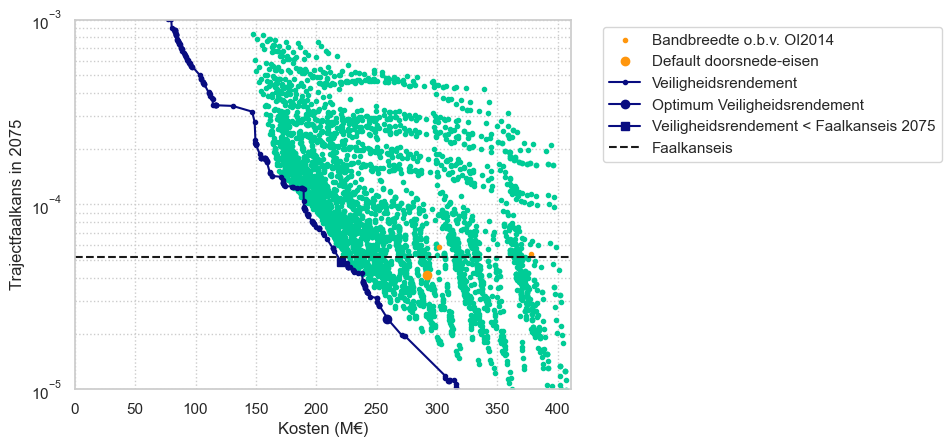

In [37]:
fig,ax = plt.subplots()
ax.scatter(cost_grid, pf_traject, color = colors[4], marker = '.')
ax.scatter(cost_specific, pf_traject_specific, color = colors[6], marker = '.', label = 'Bandbreedte o.b.v. OI2014')
# ax.plot(85858728.5666441, 5e-4, 'go')
#10-1 trajectaanpak
# ax.plot(62e6, 0.0002984669659441552, 'go', label='VRM optimaal')
ax.plot(cost_dsn, pf_dsn, color = colors[6], marker = 'o', linestyle = '', label= 'Default doorsnede-eisen')
# ax.plot(cost_vrm, pf_2075, color=colors[2], linestyle = ':', label = 'Veiligheidsrendement')
ax.plot(cost_vrm_filtered, pf_2075_filtered, color=colors[0], label = 'Veiligheidsrendement', marker = '.')
ax.plot(optimization_steps[considered_tc_step-1]['total_lcc'], traject_probs[considered_tc_step-1][1][ind_2075], marker = 'o',color = colors[0], label='Optimum Veiligheidsrendement')
ax.plot(optimization_steps[min(np.where(np.array(pf_2075)<p_max_space)[0])]['total_lcc'], traject_probs[min(np.where(np.array(pf_2075)<p_max_space)[0])][1][ind_2075], marker = 's',color = colors[0], label='Veiligheidsrendement < Faalkanseis 2075')
ax.set_xlim(left = 0, right = max(cost_grid))
ax.hlines(p_max_space, 0, 5e8, colors='k', linestyles='dashed', label='Faalkanseis')
ax.set_ylim(top=p_max *10,  bottom = p_max/10)
ax.set_xlabel('Kosten (M€)')
ax.set_ylabel('Trajectfaalkans in 2075')
ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.05, 1))
#get xtick labels and divide by 1e6 and replace
ax.set_xticklabels([f'{x/1e6:.0f}' for x in ax.get_xticks()]);
ax.grid(True, which='both', linestyle=':')

#save the figure
save_dir = Path(r'c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\vergelijkingen_uniforme_kansen')

if LE== 'full':
    plt.savefig(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_LE.png'), dpi=300, bbox_inches='tight')
elif LE == 'no':
    plt.savefig(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}.png'), dpi=300, bbox_inches='tight')
elif LE == 4:
    plt.savefig(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_N=4.png'), dpi=300, bbox_inches='tight')
else:
    plt.savefig(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_{db_path.stem}.png'), dpi=300, bbox_inches='tight')


#add veiligheidsrendement

In [23]:
dataset = pd.DataFrame([N_overflow_grid_specific, N_piping_grid_specific, N_stability_inner_grid_specific, pf_traject_specific, cost_specific],index=['N_overslag', 'N_piping', 'N_stability', 'Pf_traject', 'cost']).T
vrm_cost = cost_vrm[np.where(np.array(pf_2075)<p_max)[0][0]]
min_dsn_cost = min(np.array(cost_grid)[np.where(np.array(pf_traject)<p_max)[0]])
dataset['unsafe OI'] = dataset['Pf_traject'] > p_max_space
dataset['% cost diff VRM'] = np.divide(dataset['cost'] - vrm_cost, vrm_cost) * 100
dataset['% cost diff optimal uniform'] = np.divide(dataset['cost'] - min_dsn_cost, min_dsn_cost) * 100

if LE == True:
    dataset.to_csv(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_LE_factsheet.csv'))
elif LE == 4:
    dataset.to_csv(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_N=4_factsheet.csv'))
else:
    dataset.to_csv(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_noLE_factsheet.csv'))


Optimale eisen o.b.v. VRM


In [24]:
def get_probability_for_mechanism_in_year_per_section(assessment_step: dict[int:dict[str:list]], year:int, mechanism: MechanismEnum):
    probability_per_section = {}
    time_index = np.argwhere(np.array(assessment_step[mechanism][1]['time'])==year).flatten()[0]
    for section in assessment_step[mechanism]:
        probability_per_section[section] = assessment_step[mechanism][section]['beta'][time_index]
    return probability_per_section

voldoet_aan_eis_stap = min(np.where(np.array(pf_2075)<p_max_space)[0])
requirements_per_section = {mechanism: get_probability_for_mechanism_in_year_per_section(assessment_step=stepwise_assessment[voldoet_aan_eis_stap],
                                                                                          year=50, 
                                                                                          mechanism=mechanism) 
                                                                                          for mechanism in [MechanismEnum.OVERFLOW, MechanismEnum.PIPING, MechanismEnum.STABILITY_INNER]}
requirements_df = pd.DataFrame.from_dict(requirements_per_section)
requirements_df.to_csv(save_dir.joinpath(f'optimal_requirements_{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_LE={LE}.csv'))

Maatregelen bij pf 2075 voldoet volgens VRM

In [25]:
step = min(np.where(np.array(pf_2075)<p_max_space)[0])
measures_per_section  = get_measures_per_section_for_step(measures_per_step, step+1)
measures_per_section

section_parameters = {}

for section in measures_per_section.keys():
    section_parameters[section] = []
    for measure in measures_per_section[section][0]:
        parameters = get_measure_parameters(measure, db_path)
        parameters.update(get_measure_costs(measure, db_path))
        parameters.update(get_measure_type(measure, db_path))
        section_parameters[section].append(parameters)
vrm_measures_df = measure_per_section_to_df(measures_per_section, section_parameters)
vrm_measures_df.to_csv(save_dir.joinpath(f'VRM_2075_measures_{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_LE={LE}.csv'))


In [ ]:
base_cost = calculate_cost(pf_to_beta(1./10), pf_to_beta(1./10), pf_to_beta(p_max/317), measures_df_with_dsn)
adapted_cost = calculate_cost(pf_to_beta(1./10), pf_to_beta(1./10), pf_to_beta(p_max/53), measures_df_with_dsn)

print(f"Stabiliteitseis")
print(f"Base cost is {base_cost[0]}")
print(f"Adapted cost is {adapted_cost[0]}")

base_cost = calculate_cost(pf_to_beta(1./10)   , pf_to_beta(p_max/107),    pf_to_beta(1./10), measures_df_with_dsn)
adapted_cost = calculate_cost(pf_to_beta(1./10), pf_to_beta(p_max/640),  pf_to_beta(1./10),measures_df_with_dsn)

print(f"Pipingeis")
print(f"Base cost is {base_cost[0]}")
print(f"Adapted cost is {adapted_cost[0]}")

base_cost = calculate_cost(pf_to_beta(.25* p_max)   , pf_to_beta(1./10),     pf_to_beta(1./10), measures_df_with_dsn)

print(f"Alleen hoogte")
print(f"Base cost is {base_cost[0]}")


base_cost = calculate_cost(pf_to_beta(1./10)   , pf_to_beta(p_max/107),    pf_to_beta(p_max/317), measures_df_with_dsn)
adapted_cost = calculate_cost(pf_to_beta(1./10), pf_to_beta(p_max/640),  pf_to_beta(p_max/53),measures_df_with_dsn)

print(f"Uitwisselen")
print(f"Base cost is {base_cost[0]}")
print(f"Adapted cost is {adapted_cost[0]}")

base_cost = calculate_cost(pf_to_beta(.24* p_max)   , pf_to_beta(p_max/107),    pf_to_beta(p_max/317), measures_df_with_dsn)
adapted_cost = calculate_cost(pf_to_beta(.24* p_max), pf_to_beta(p_max/640),  pf_to_beta(p_max/53),measures_df_with_dsn)

print(f"Alle mechanismen, uitwisselen")
print(f"Base cost is {base_cost[0]}")
print(f"Adapted cost is {adapted_cost[0]}")

print(f"Veiligheidsrendement is {optimization_steps[min(np.where(np.array(pf_2075)<p_max_space)[0])]['total_lcc']}")

#find the index where cost is minimal and pf_traject is below p_max
min_idx = np.where(np.array(pf_traject)<p_max_space)[0][np.argmin(np.array(cost_grid)[np.where(np.array(pf_traject)<p_max_space)])]

betas_list = [value for value in itertools.product(overflow_grid, piping_grid, stability_inner_grid)]
N_values = np.array(p_max)/beta_to_pf(list(betas_list[min_idx]))
#print the N-values for the optimal uniform solution
print(f'optimaal uniform: N_overslag = {N_values[0]}, N_piping = {N_values[1]}, N_stability = {N_values[2]}')
print(f'Kosten optimaal uniform: {cost_grid[min_idx]}')

Stabiliteitseis
Base cost is 60992888.30508
Adapted cost is 48817398.4749
Pipingeis
Base cost is 108260774.82892
Adapted cost is 228154949.09833995
Alleen hoogte
Base cost is 80563241.92684181
Uitwisselen
Base cost is 143580202.08984
Adapted cost is 246795698.93751997
Alle mechanismen, uitwisselen
Base cost is 219715928.09137565
Adapted cost is 314314706.5080204
Veiligheidsrendement is 220405646.7715654
optimaal uniform: N_overslag = 6.000000000000009, N_piping = 120.00000000000041, N_stability = 639.9999999999991
Kosten optimaal uniform: 227728876.10660714


Betas van maatregelen horend bij optimale uniforme eisen

In [27]:
overflow_beta, piping_beta, stability_beta = list(betas_list[min_idx])
cost, pf, measures_optimal_uniform = calculate_cost(overflow_beta, piping_beta, stability_beta, measures_df_with_dsn)
measures_optimal_uniform.to_csv(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_optimal_uniform_N={LE}.csv'))

Maatregelen horend bij optimaal uniform

In [28]:
measures_optimal_uniform.head()

,measure_result,section_id,Overflow,Piping,StabilityInner,measure_type_id,cost,section_length,Overflow_dsn,N_piping,Piping_dsn,N_stability,StabilityInner_dsn
0,31,1,4.362467,4.805657,7.991574,99,7.069979e+06,359.0,4.362467,1.196667,4.841450,4.0,8.160708
25,236,2,4.287667,4.819357,7.991574,99,2.492708e+06,226.0,4.287667,1.000000,4.819357,4.0,8.160708
42,453,3,4.225100,4.609448,5.664515,99,7.752619e+06,791.0,4.225100,2.636667,4.807113,4.0,5.897701
107,675,4,4.243533,4.810611,5.971327,99,4.006469e+06,354.0,4.243533,1.180000,4.843586,4.0,6.193526
140,908,5,4.387800,4.602033,6.852390,99,8.822001e+06,766.0,4.387800,2.553333,4.793546,4.0,7.047955


In [29]:
parameters = []
for count, row in measures_optimal_uniform.iterrows():
    row_params = get_measure_parameters(row.measure_result, db_path)
    measure_df_subset = measures_df.loc[row.measure_result]
    if type(measure_df_subset) == pd.Series:
        row_params['cost'] = measure_df_subset.cost
    else:
        row_params['cost'] = measure_df_subset.loc[np.round(measure_df_subset.Piping,2) == np.round(row.Piping,2)].cost.values[0]
    # row_params.update(get_measure_costs(row.measure_result, db_path))
    row_params.update(get_measure_type(row.measure_result, db_path))
    if row.measure_type_id == 99:
        row_params['name'] = 'Verticaal Zanddicht Geotextiel + Grondversterking binnenwaarts'
    row_params['section_id'] = row.section_id
    parameters.append(row_params)
parameters_df = pd.DataFrame(parameters)
parameters_df = parameters_df[['section_id', 'name', 'cost', 'dcrest', 'dberm', 'l_stab_screen']]
parameters_df.to_csv(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_optimal_uniform_N={LE}_parameters.csv'))


Standaardbegroting

In [ ]:
overflow_beta, piping_beta, stability_beta = target_beta_grid_specific[0]
cost, pf, measures_standard = calculate_cost(overflow_beta, piping_beta, stability_beta, measures_df_with_dsn)
measures_standard.to_csv(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_optimal_uniform_N={LE}.csv'))

parameters = []
for count, row in measures_standard.iterrows():
    row_params = get_measure_parameters(row.measure_result, db_path)
    measure_df_subset = measures_df.loc[row.measure_result]
    if type(measure_df_subset) == pd.Series:
        row_params['cost'] = measure_df_subset.cost
    else:
        row_params['cost'] = measure_df_subset.loc[np.round(measure_df_subset.Piping,2) == np.round(row.Piping,2)].cost.values[0]
    # row_params.update(get_measure_costs(row.measure_result, db_path))
    row_params.update(get_measure_type(row.measure_result, db_path))
    if row.measure_type_id == 99:
        row_params['name'] = 'Verticaal Zanddicht Geotextiel + Grondversterking binnenwaarts'
    row_params['section_id'] = row.section_id
    parameters.append(row_params)
parameters_df = pd.DataFrame(parameters)
parameters_df = parameters_df[['section_id', 'name', 'cost', 'dcrest', 'dberm', 'l_stab_screen']]
parameters_df.to_csv(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_standard_N={LE}_parameters.csv'))

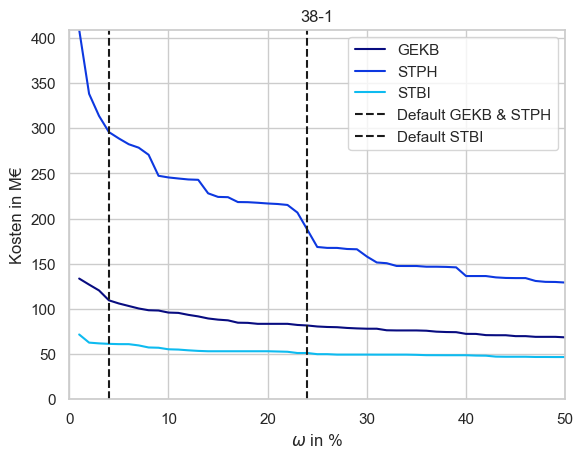

In [389]:
#relation between omega and cost for overflow
omega_values = np.arange(0.01, 0.51, 0.01)
cost_values_overflow = []
cost_values_piping = []
cost_values_stability = []
N_LE_piping = traject_length * a_piping / b_piping
N_LE_stability = traject_length * a_stability_inner / b_stability_inner
for omega in omega_values:
    beta_t = pf_to_beta(np.multiply(p_max, omega))
    results = calculate_cost(beta_t, pf_to_beta(1./10), pf_to_beta(1./10), measures_df_with_dsn)
    cost_values_overflow.append(results[0]/1e6)

    #relation between omega and cost for piping
    beta_t = pf_to_beta(np.multiply(p_max, omega)/N_LE_piping)
    results = calculate_cost(pf_to_beta(1./10), beta_t, pf_to_beta(1./10), measures_df_with_dsn)
    cost_values_piping.append(results[0]/1e6)

    #relation between omega and cost for stability
    beta_t = pf_to_beta(np.multiply(p_max, omega)/N_LE_stability)
    results = calculate_cost(pf_to_beta(1./10), pf_to_beta(1./10), beta_t, measures_df_with_dsn)
    cost_values_stability.append(results[0]/1e6)


fig, ax = plt.subplots()
ax.plot(omega_values* 100, cost_values_overflow, color = colors[0], label = 'GEKB')
ax.plot(omega_values* 100, cost_values_piping, color = colors[1], label = 'STPH')
ax.plot(omega_values* 100, cost_values_stability, color = colors[2], label = 'STBI')
ax.vlines(0.24*100, 0, max(max(cost_values_overflow), max(cost_values_piping), max(cost_values_stability)), colors='k', linestyles='dashed', label='Default GEKB & STPH')
ax.vlines(0.04*100, 0, max(max(cost_values_overflow), max(cost_values_piping), max(cost_values_stability)), colors='k', linestyles='dashed', label='Default STBI')


ax.set_ylabel('Kosten in M€')
ax.set_xlabel(r'$\omega$ in %')
ax.set_xlim(left = 0, right = 50)
ax.set_ylim(bottom = 0, top = max(max(cost_values_overflow), max(cost_values_piping), max(cost_values_stability)))
ax.legend()
ax.set_title(DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name)
plt.savefig(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_omega_kosten.png'), dpi=300, bbox_inches='tight')




In [390]:
measures_df_with_dsn_piping = measures_df_with_dsn.copy()
measures_df_with_dsn_piping['StabilityInner_dsn'] = 8.0
measures_df_with_dsn_piping['StabilityInner'] = 8.0
measures_df_with_dsn_piping['Overflow_dsn'] = 8.0
measures_df_with_dsn_piping['Overflow'] = 8.0

measures_df_with_dsn_stability = measures_df_with_dsn.copy()
measures_df_with_dsn_stability['Piping_dsn'] = 8.0
measures_df_with_dsn_stability['Piping'] = 8.0
measures_df_with_dsn_stability['Overflow_dsn'] = 8.0
measures_df_with_dsn_stability['Overflow'] = 8.0

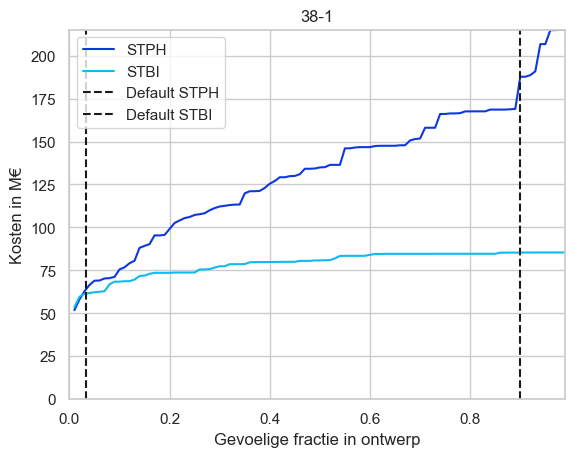

In [391]:
#relation between omega and cost for overflow
a_values = np.arange(0.01, 1.0, 0.01)
cost_values_piping = []
cost_values_stability = []
pf_traject_piping = []
pf_traject_stability = []

for a_value in a_values:
    #relation between omega and cost for piping
    beta_t = pf_to_beta(np.multiply(np.multiply(p_max, .24), b_piping/np.multiply(a_value, traject_length)))
    results = calculate_cost(pf_to_beta(1./10), beta_t, pf_to_beta(1./10), measures_df_with_dsn_piping)
    cost_values_piping.append(results[0]/1e6)
    pf_traject_piping.append(results[1])


    #relation between omega and cost for stability
    beta_t = pf_to_beta(np.multiply(np.multiply(p_max, .04), b_stability_inner/np.multiply(a_value, traject_length)))
    results = calculate_cost(pf_to_beta(1./10), pf_to_beta(1./10), beta_t, measures_df_with_dsn_stability)
    cost_values_stability.append(results[0]/1e6)
    pf_traject_stability.append(results[1])

fig, ax = plt.subplots()
ax.plot(a_values, cost_values_piping, color = colors[1], label = 'STPH')
ax.plot(a_values, cost_values_stability, color = colors[2], label = 'STBI')
ax.vlines(a_piping, 0, max(max(cost_values_overflow), max(cost_values_piping), max(cost_values_stability)), colors='k', linestyles='dashed', label='Default STPH')
ax.vlines(a_stability_inner, 0, max(max(cost_values_overflow), max(cost_values_piping), max(cost_values_stability)), colors='k', linestyles='dashed', label='Default STBI')


ax.set_ylabel('Kosten in M€')
ax.set_xlabel(r'Gevoelige fractie in ontwerp')
ax.set_xlim(left = 0, right = max(a_values))
ax.set_ylim(bottom = 0, top = max(max(cost_values_overflow), max(cost_values_piping), max(cost_values_stability)))
ax.legend()
ax.set_title(DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name)

plt.savefig(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_a_vs_kosten_N={LE}.png'), dpi=300, bbox_inches='tight')


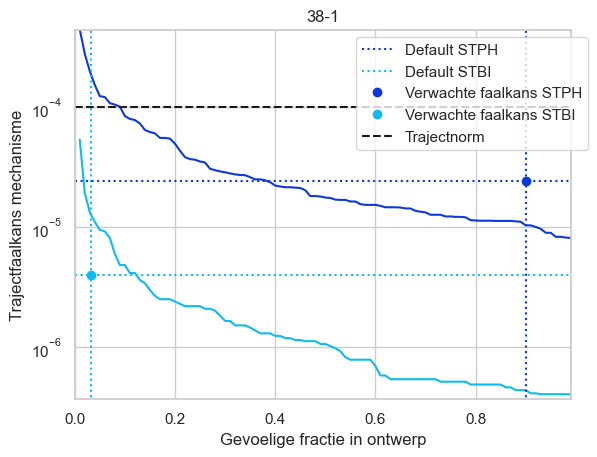

In [392]:
fig, ax = plt.subplots()
ax.plot(a_values, pf_traject_piping, color=colors[1])
ax.plot(a_values, pf_traject_stability, color = colors[2])
# ax.plot(a_values, np.add(pf_traject_stability,pf_traject_piping), color = colors[6])

ax.set_ylabel('Trajectfaalkans mechanisme')
ax.set_xlabel(r'Gevoelige fractie in ontwerp')
ax.set_xlim(left = 0, right= max(a_values))
ax.set_ylim(bottom = min(min(pf_traject_piping), min(pf_traject_stability))/1.1, top = max(max(pf_traject_piping), max(pf_traject_stability)))
ax.set_yscale('log')
ax.vlines(a_piping, 0, max(max(pf_traject_piping), max(pf_traject_stability)), colors=colors[1], linestyles='dotted', label='Default STPH')
ax.vlines(a_stability_inner, 0, max(max(pf_traject_piping), max(pf_traject_stability)), colors=colors[2], linestyles='dotted', label='Default STBI')

ax.hlines(0.24*p_max, 0, max(a_values), colors=colors[1], linestyles='dotted')
ax.hlines(0.04*p_max, 0, max(a_values), colors=colors[2], linestyles='dotted')
# ax.hlines(0.28*p_max, 0, max(a_values), colors=colors[6], linestyles='dotted', label='Faalkansruimte samen')
ax.plot(a_piping, 0.24*p_max, color=colors[1], marker='o', linestyle = '', label='Verwachte faalkans STPH')
ax.plot(a_stability_inner, 0.04*p_max, color=colors[2], marker='o', linestyle = '', label='Verwachte faalkans STBI')
ax.hlines(p_max, 0, max(a_values), colors='k', linestyles='dashed', label='Trajectnorm')
ax.set_title(DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name)
ax.legend(bbox_to_anchor=(1.05, 1))
plt.savefig(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_a_vs_pf_N={LE}.png'), dpi=300, bbox_inches='tight')


Stel we willen puur een pipingopgave oplossen, we gaan uit van standaard waarden. Hoe is dan de faalkans/n/beta over de vakken verdeeld?

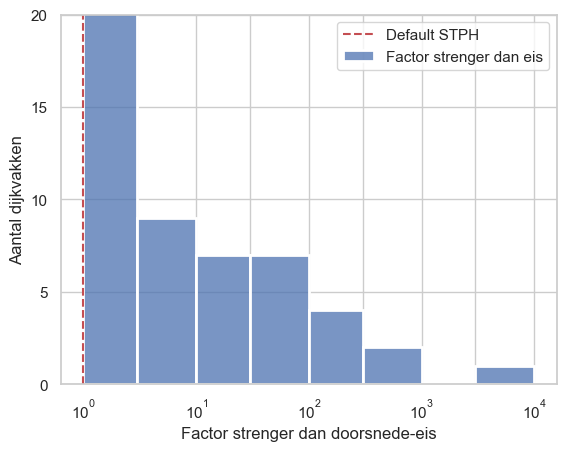

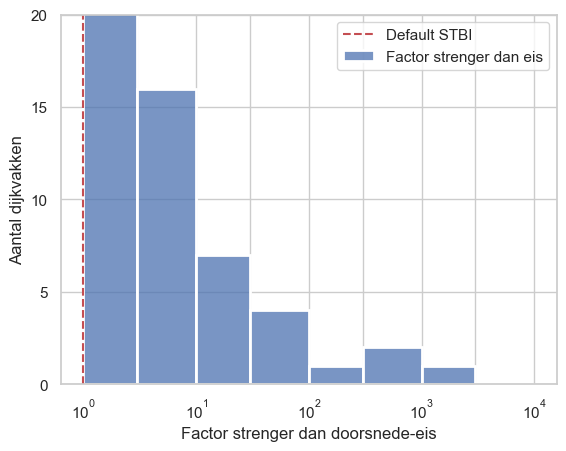

In [393]:
beta_t = pf_to_beta(p_max * omega_piping * (b_piping / (a_piping * traject_length)))
results = calculate_cost(pf_to_beta(1./10), beta_t, pf_to_beta(1./10), measures_df_with_dsn_piping)
piping_betas = results[2].Piping_dsn
binrange = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000]

fig, ax = plt.subplots()
sns.histplot(beta_to_pf(beta_t)/beta_to_pf(piping_betas), bins = binrange, ax = ax, label= 'Factor strenger dan eis', linewidth= 2)
ax.vlines(1, 0, 100, colors='r', linestyles='dashed', label='Default STPH')
ax.set_xlabel('Factor strenger dan doorsnede-eis')
ax.set_ylabel('Aantal dijkvakken')
ax.set_ylim(top=20)
ax.set_xscale('log')
ax.set_xticks(binrange)
ax.set_yticks([0, 5, 10, 15, 20])
ax.legend()

#same for STBI
beta_t = pf_to_beta(p_max * omega_stability_inner * (b_stability_inner / (a_stability_inner * traject_length)))
results = calculate_cost(pf_to_beta(1./10), pf_to_beta(1./10), beta_t, measures_df_with_dsn_stability)
stability_betas = results[2].StabilityInner_dsn

fig, ax = plt.subplots()
sns.histplot(beta_to_pf(beta_t)/beta_to_pf(stability_betas), bins = binrange, ax = ax, label= 'Factor strenger dan eis', linewidth=2)
ax.vlines(1, 0, 100, colors='r', linestyles='dashed', label='Default STBI')
ax.set_xlabel('Factor strenger dan doorsnede-eis')
ax.set_ylabel('Aantal dijkvakken')
ax.set_ylim(top=20)
ax.set_xscale('log')
ax.set_xticks(binrange)
ax.set_yticks([0, 5, 10, 15, 20])

ax.legend()


Optimale uniforme eisen beter bekeken